In [ ]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")

In [ ]:
!nvidia-smi

In [ ]:
import os
import random
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from torchvision import transforms

from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import pandas as pd

from accelerate import Accelerator
from diffusers import (
    AutoencoderKL, 
    UNet2DConditionModel, 
    DDPMScheduler, 
    AutoPipelineForText2Image, 
    StableDiffusionPipeline
)
from diffusers.optimization import get_scheduler

from peft import LoraConfig, get_peft_model

from transformers import (
    CLIPTextModel, 
    CLIPTokenizer, 
    CLIPModel, 
    CLIPProcessor
)

from tqdm.auto import tqdm

from safetensors.torch import save_file

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

## Prepare Dataset

In [ ]:
pip install matplotlib
pip install pillow

In [3]:
import os
from pathlib import Path
import random
from PIL import Image, ImageOps  # Pillow library for image processing

# ---- USER SETTINGS ----
# Where original images are stored
IMAGES_DIR = "images"  # folder containing .jpg/.png etc.
# Where original text descriptions are stored
TEXTS_DIR = "texts"    # folder containing .txt files
# Where to save the prepared dataset
OUTPUT_DIR = "dataset"
# Image size (Stable Diffusion usually uses 512x512)
RESOLUTION = 512
# Fraction of images to use for validation (testing)
VAL_FRACTION = 0.1
# Random seed so the split is the same every time
SEED = 42

# ---- START OF SCRIPT ----

# Convert to Path objects for easier handling
images_path = Path(IMAGES_DIR)
texts_path = Path(TEXTS_DIR)
output_path = Path(OUTPUT_DIR)

# Create output folders
(output_path / "images").mkdir(parents=True, exist_ok=True)

# List of valid image file extensions
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".webp"}

# This will hold (image_filename, caption_text)
pairs = []

# Loop over all files in the images folder
for img_file in images_path.iterdir():
    if img_file.suffix.lower() in IMAGE_EXTENSIONS:
        # Match the image with its text file (same name, .txt extension)
        txt_file = texts_path / (img_file.stem + ".txt")
        if not txt_file.exists():
            print(f"Warning: No caption found for {img_file.name}, skipping.")
            continue
        
        # Read the caption text
        caption = txt_file.read_text(encoding="utf-8").strip()
        
        # Open the image and process it
        img = Image.open(img_file).convert("RGB")
        # Center crop and resize to square
        img = ImageOps.fit(img, (RESOLUTION, RESOLUTION), Image.LANCZOS)
        
        # Save processed image into dataset/images folder
        out_img_path = output_path / "images" / (img_file.stem + ".jpg")
        img.save(out_img_path, quality=95)
        
        # Add to list (filename only, not full path)
        pairs.append((img_file.stem + ".jpg", caption))

print(f"Found {len(pairs)} image-caption pairs.")

# Write captions.txt
with open(output_path / "captions.txt", "w", encoding="utf-8") as f:
    for filename, caption in pairs:
        f.write(f"{filename}|{caption}\n")
print("Wrote captions.txt")

# Split into train and val sets
random.seed(SEED)
random.shuffle(pairs)
n_val = max(1, int(len(pairs) * VAL_FRACTION))
val_pairs = pairs[:n_val]
train_pairs = pairs[n_val:]

with open(output_path / "train.txt", "w", encoding="utf-8") as f:
    for filename, caption in train_pairs:
        f.write(f"{filename}|{caption}\n")

with open(output_path / "val.txt", "w", encoding="utf-8") as f:
    for filename, caption in val_pairs:
        f.write(f"{filename}|{caption}\n")

print(f"Train/Val split complete. Train: {len(train_pairs)}, Val: {len(val_pairs)}")
print("Dataset is ready in:", output_path)

Found 113 image-caption pairs.
Wrote captions.txt
Train/Val split complete. Train: 102, Val: 11
Dataset is ready in: dataset


## LoRA

In [1]:
# ==============================================================================
# 0. IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from pathlib import Path
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler
from peft import LoraConfig, get_peft_model # PEFT is the library that makes LoRA easy
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm # A library to show a progress bar
import torchvision.utils as vutils
import os

In [2]:
# = a helper function to print a clean separator line
def print_line():
    print("=" * 80)

In [3]:
# ==============================================================================
# 1. TRAINING CONFIGURATION
# ==============================================================================
# All the settings training run
class TrainingConfig:
    # --- Dataset and Paths ---
    # The base Stable Diffusion model that is being fine-tuned.
    model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
    # The path to dataset folder
    dataset_path = Path("dataset") 
    # Where to save the trained LoRA weights.
    output_dir = "ghiblivis-LORA(NEW)"
    
    # --- Image and Batching ---
    # The resolution of images. It's best to match the model's training resolution.
    resolution = 512 
    # How many images to process at once. Reduce if out of memory (OOM error).
    batch_size = 1
    
    # --- Training Parameters ---
    # How many times to go through the entire dataset.
    num_epochs = 10 #10
    # The learning rate is how big of a step the model takes during training.
    # 1e-4 (0.0001) is a common starting point for LoRA.
    learning_rate = 1e-4
    # a scheduler to adjust the learning rate during training for better results.
    lr_scheduler = "cosine" # "linear", "cosine", "constant"
    # mixed precision training (fp16) to speed up training and save memory.
    mixed_precision = "fp16" # "no", "fp16", "bf16"

    # --- LoRA Specific Parameters ---
    # `r` is the "rank" of the LoRA. A higher rank means more trainable parameters,
    # potentially more detail, but also a larger file size. 8 is a good starting point.
    lora_rank = 8
    # `alpha` is a scaling factor for the LoRA weights. A common practice is to set
    # it to the same value as the rank.
    lora_alpha = 8
    
# Create an instance of the config
config = TrainingConfig()

print_line()
print("Starting LoRA Fine-Tuning for 'ghiblivis' Style")
print(f"Base Model: {config.model_name}")
print(f"Dataset Path: {config.dataset_path}")
print(f"Output Directory: {config.output_dir}")
print_line()


Starting LoRA Fine-Tuning for 'ghiblivis' Style
Base Model: stable-diffusion-v1-5/stable-diffusion-v1-5
Dataset Path: dataset
Output Directory: ghiblivis-LORA(NEW)


In [4]:
# ==============================================================================
# 2. CUSTOM DATASET CLASS
# ==============================================================================
# This class will load images and captions from the `train.txt` file.
class GhibliVisDataset(Dataset):
    def __init__(self, dataset_path, tokenizer, metadata_file="train.txt"):
        self.dataset_path = Path(dataset_path)
        self.tokenizer = tokenizer
        
        # Define the path to the images and the training metadata file
        self.image_dir = self.dataset_path / "images"
        metadata_file = self.dataset_path / metadata_file
        
        # Load the metadata (image filename and caption)
        with open(metadata_file, "r", encoding="utf-8") as f:
            self.metadata = [line.strip().split("|") for line in f.readlines()]

    def __len__(self):
        # Returns the total number of items in the dataset
        return len(self.metadata)

    def __getitem__(self, idx):
        # This method is called to get a single data sample (image + caption)
        img_name, caption = self.metadata[idx]
        
        # Load the image
        img_path = self.image_dir / img_name
        image = Image.open(img_path).convert("RGB") # Ensure image is in RGB format
        
        # Process the image: resize, convert to a tensor, and normalize
        # We don't need complex augmentations, just basic processing.
        image = image.resize((config.resolution, config.resolution))
        image = torch.tensor(list(image.getdata()), dtype=torch.uint8).reshape(config.resolution, config.resolution, 3)
        image = image.permute(2, 0, 1) / 255.0 # HWC to CHW and normalize to [0, 1]
        image = (image - 0.5) * 2.0 # Normalize to [-1, 1], which the model expects
        
        # Process the text caption
        # The tokenizer converts the text caption into numbers (tokens) that the model can understand.
        text_inputs = self.tokenizer(
            caption,
            padding="max_length", # Pad to a fixed length
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_input_ids = text_inputs.input_ids.squeeze()
        
        return {
            "pixel_values": image,
            "input_ids": text_input_ids,
        }

In [ ]:
# ==============================================================================
# 3. MODEL LOADING AND PREPARATION
# ==============================================================================

# --- Load Models ---
# The Tokenizer handles converting text to numbers.
tokenizer = CLIPTokenizer.from_pretrained(config.model_name, subfolder="tokenizer")
# The Text Encoder turns those numbers into embeddings (vectors) that represent the meaning of the text.
text_encoder = CLIPTextModel.from_pretrained(config.model_name, subfolder="text_encoder")
# The VAE (Variational Autoencoder) compresses images into a smaller "latent" space and decompresses them back.
# This makes the diffusion process much faster.
vae = AutoencoderKL.from_pretrained(config.model_name, subfolder="vae")
# The UNet is the core of the diffusion model. It predicts the noise in a noisy image.
# This is the component that will be fine-tuned with LoRA.
unet = UNet2DConditionModel.from_pretrained(config.model_name, subfolder="unet")
# The Noise Scheduler manages the process of adding noise to images during training.
noise_scheduler = DDPMScheduler.from_pretrained(config.model_name, subfolder="scheduler")
print_line()
print(type(tokenizer))
print(type(text_encoder))
print(type(vae))
print(type(unet))
print(type(noise_scheduler))
print_line()
# --- Freeze Original Model Weights ---
# We don't want to train the original, massive model. We freeze its weights so they don't change.
# Only the small, new LoRA layers will be trained.
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# #========
# # Freeze original weights ‚Äî only LoRA layers will train
# for model in [vae, text_encoder, unet]:
#     for param in model.parameters():
#         param.requires_grad = False
# #========


# --- Add LoRA Adapters to the UNet ---
# Injecting LoRA layers into the UNet's attention blocks.
lora_config = LoraConfig(
    r=config.lora_rank,
    lora_alpha=config.lora_alpha,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"], # Standard layers to target for LoRA
    lora_dropout=0.1,
    bias="none",
)
# `get_peft_model` wraps our UNet and adds the LoRA layers for us.
unet = get_peft_model(unet, lora_config)

# Let's see how many parameters we're actually training. It will be a tiny fraction!
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print_line()
    print(
        f"Trainable params: {trainable_params} || All params: {all_param} || "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
    print_line()
    
print_trainable_parameters(unet)

# --- Dataset and DataLoader ---
train_dataset = GhibliVisDataset(config.dataset_path, tokenizer)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True, # Shuffle the data each epoch for better training
    batch_size=config.batch_size,
)

val_dataset = GhibliVisDataset(config.dataset_path, tokenizer, metadata_file="val.txt")
val_dataloader = DataLoader(
    val_dataset,
    shuffle=False,  # usually no shuffle in validation
    batch_size=config.batch_size,
)

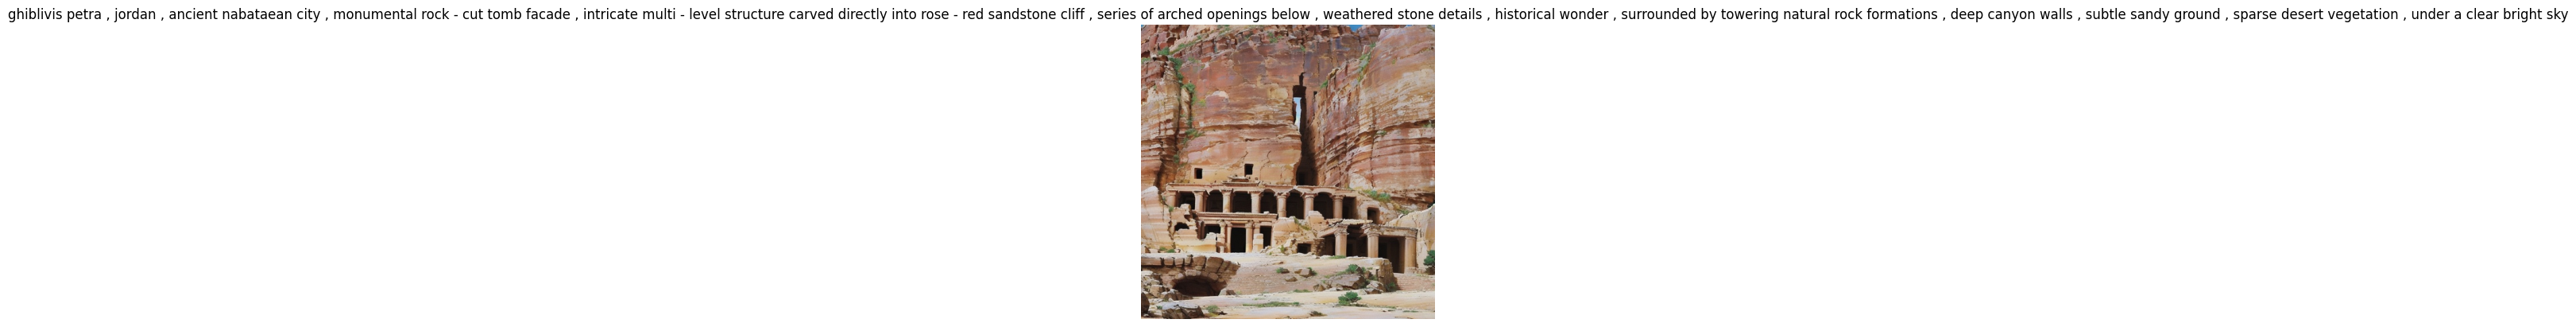

In [13]:
import matplotlib.pyplot as plt
import torch

# Get first sample
sample = train_dataset[0]

# Extract image tensor
image_tensor = sample["pixel_values"]  # shape: (C, H, W), values in [-1, 1]

# Convert from [-1, 1] to [0, 1]
image_tensor = (image_tensor + 1) / 2

# Move to CPU and convert to numpy (H, W, C)
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

# Decode label
caption = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

# Plot
plt.imshow(image_np)
plt.title(caption)
plt.axis("off")
plt.show()

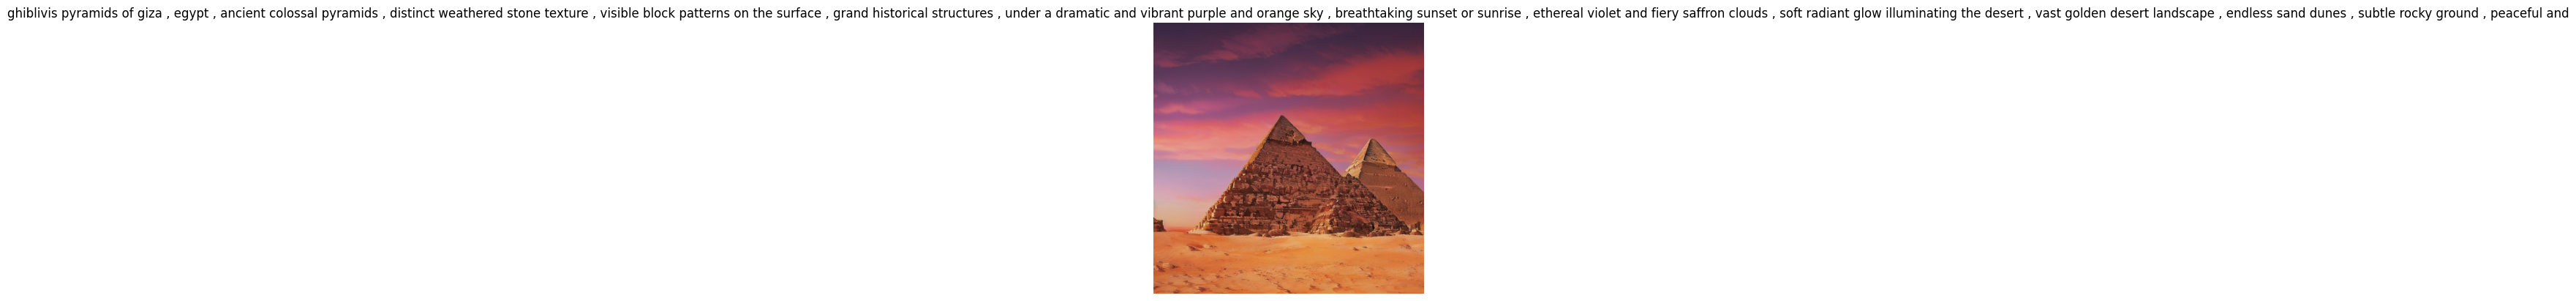

In [15]:
import matplotlib.pyplot as plt

# Get one batch from the DataLoader
batch = next(iter(train_dataloader))

# Extract first image from the batch
image_tensor = batch["pixel_values"][0]  # shape: (C, H, W), values in [-1, 1]

# Convert from [-1, 1] to [0, 1]
image_tensor = (image_tensor + 1) / 2

# Convert to numpy for plotting
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

# Decode first caption in batch
caption = tokenizer.decode(batch["input_ids"][0], skip_special_tokens=True)

# Show image
plt.imshow(image_np)
plt.title(caption)
plt.axis("off")
plt.show()


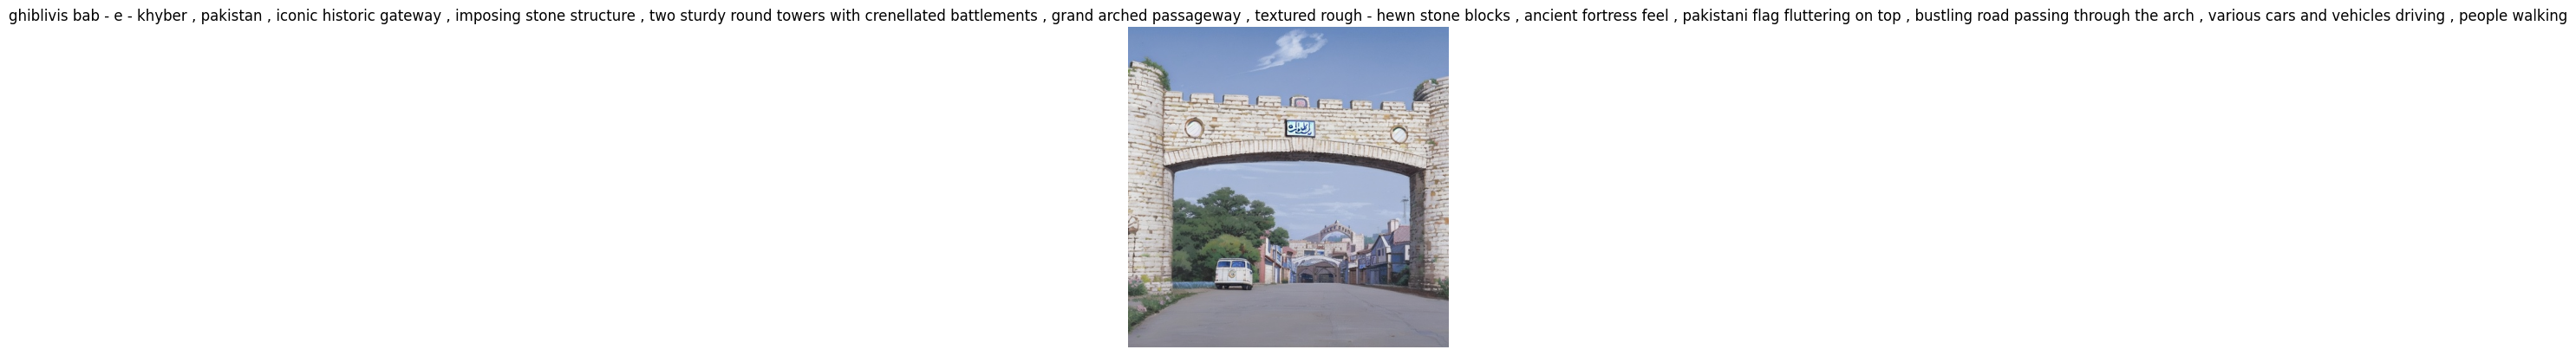

In [16]:
import matplotlib.pyplot as plt

# Create the iterator
val_iter = iter(val_dataloader)

# Get first batch
batch1 = next(val_iter)

# Get second batch
batch2 = next(val_iter)

# Extract first image from the batch
image_tensor = batch2["pixel_values"][0]  # shape: (C, H, W), values in [-1, 1]

# Convert from [-1, 1] to [0, 1]
image_tensor = (image_tensor + 1) / 2

# Convert to numpy for plotting
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

# Decode first caption in batch
caption = tokenizer.decode(batch2["input_ids"][0], skip_special_tokens=True)

# Show image
plt.imshow(image_np)
plt.title(caption)
plt.axis("off")
plt.show()

In [7]:
# ==============================================================================
# 4. TRAINING SETUP
# ==============================================================================

# --- Optimizer ---
# The optimizer is responsible for updating the model's weights (our LoRA layers).
# AdamW is the standard choice for training transformer-based models.
optimizer = torch.optim.AdamW(
    unet.parameters(), # We only pass the UNet's parameters, which PEFT has filtered to be just the LoRA layers.
    lr=config.learning_rate,
)



# --- Learning Rate Scheduler ---
# This adjusts the learning rate over the course of training.
lr_scheduler = get_scheduler(
    config.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# --- Initialize Accelerator ---
# Accelerator will handle device placement (moving models/data to GPU) and mixed precision.
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=1,
)

# Prepare everything for training with the accelerator
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# We also need to move the text_encoder and vae to the correct device (GPU).
# Since we are not training them, we don't need to `prepare` them with the accelerator.
text_encoder.to(accelerator.device)
vae.to(accelerator.device)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [ ]:
# ==============================================================================
# 5. THE TRAINING LOOP WITH VALIDATION
# ==============================================================================

epoch_losses = []
val_losses = []

print("Starting training loop...")

for epoch in range(config.num_epochs):
    unet.train()  # Set model to training mode
    batch_losses = []
    progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{config.num_epochs}")

    for step, batch in enumerate(train_dataloader):
        # Move batch to device
        batch = {k: v.to(accelerator.device) for k, v in batch.items()}

        with accelerator.accumulate(unet):
            # 1. Text embeddings (no grad on text encoder)
            with torch.no_grad():
                text_embeddings = text_encoder(batch["input_ids"])[0]

            # 2. Encode images to latents (no grad on VAE)
            with torch.no_grad():
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # 3. Create noise and noisy latents
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 4. Predict noise
            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            # 5. Compute loss (MSE)
            loss = F.mse_loss(noise_pred, noise)

            # 6. Backpropagation
            accelerator.backward(loss)

            # Clip gradients if synced
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)

            # 7. Optimizer step and scheduler update
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        batch_losses.append(loss.item())
        progress_bar.update(1)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    progress_bar.close()
    epoch_avg_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(epoch_avg_loss)
    
    # -------------------
    # Validation loop
    # -------------------
    unet.eval()  # Set model to eval mode
    val_batch_losses = []

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = {k: v.to(accelerator.device) for k, v in val_batch.items()}

            text_embeddings = text_encoder(val_batch["input_ids"])[0]
            latents = vae.encode(val_batch["pixel_values"]).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            val_loss = F.mse_loss(noise_pred, noise)
            val_batch_losses.append(val_loss.item())

    val_avg_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_losses.append(val_avg_loss)

    print(f"Epoch {epoch+1} training loss: {epoch_avg_loss:.4f}")
    print(f"Epoch {epoch+1} validation loss: {val_avg_loss:.4f}")
    print("="*40)


In [9]:
# ==============================================================================
# 6. SAVE THE TRAINED LORA WEIGHTS
# ==============================================================================
print_line()
print("Training finished!")

# unwrap_model is needed to get the original PEFT model back from the accelerator.
unwrapped_unet = accelerator.unwrap_model(unet)

# `save_pretrained` will save only the LoRA weights (the "adapter") into the output directory.
# This file will be very small (a few megabytes).
unwrapped_unet.save_pretrained(config.output_dir)

print(f"LoRA weights saved to: {os.path.abspath(config.output_dir)}")
print("These weights can be used in the StableDiffusionPipeline.")
print_line()

Training finished!
LoRA weights saved to: C:\Users\Dell - G15\Desktop\Thesis Code\ghiblivis-LORA(NEW)
You can now use these weights for inference in applications like AUTOMATIC1111 or other diffusers scripts.


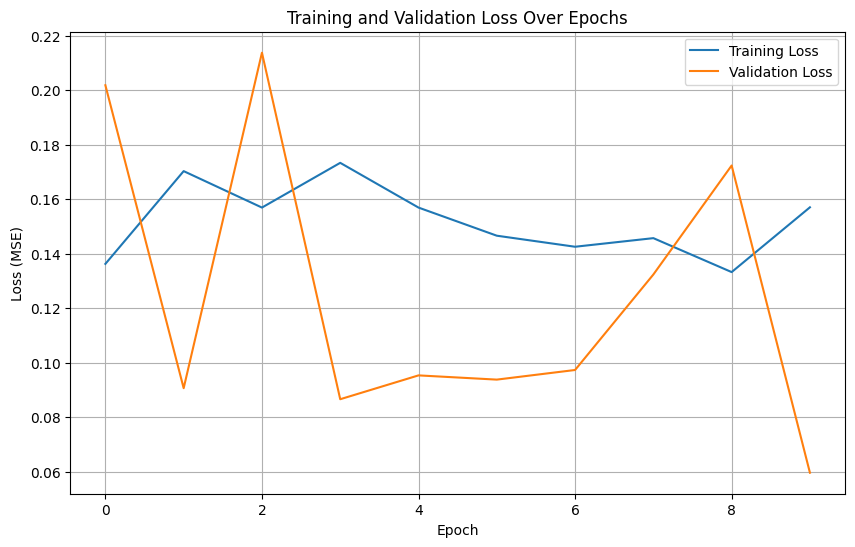

In [10]:
# ==============================================================================
# 7. TRAIN AND VALIDATION LOSS FOR LORA
# ==============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ==============================================================================
# 8. LOAD THE TRAINED LORA WEIGHTS INTO PIPELINE AND GENERATE IMAGES
# ==============================================================================


from diffusers import AutoPipelineForText2Image
import torch
import os

# Free GPU memory
torch.cuda.empty_cache()

# Load LoRA pipeline
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA weights
pipeline.load_lora_weights(
    "./ghiblivis-LORA(NEW)", 
    weight_name="adapter_model.safetensors"  
)

# Prompt
prompt = ("ghiblivis Sydney Opera House, Sydney, Australia, iconic architectural landmark, distinctive white shell-like roofs, layered sail-like structures, intricate ceramic tiles from above, vast shimmering blue Sydney Harbour waters, distant ferries, serene reflections on the water, lush green headlands, towering skyscrapers, clear blue sky with soft white clouds, high aerial view, bird's eye perspective, whimsical, dreamlike, rich vibrant colors, majestic harbour scene")
# Generate image
image = pipeline(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

# Save output
os.makedirs("outputs", exist_ok=True)
output_path = os.path.join("ghiblivis-LORA(NEW)", "5lora_test.png")
image.save(output_path)

print("üñº Test image saved to:", os.path.abspath(output_path))


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
Token indices sequence length is longer than the specified maximum sequence length for this model (92 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['eye per

  0%|          | 0/30 [00:00<?, ?it/s]

üñº Test image saved to: C:\Users\Dell - G15\Desktop\Thesis Code\ghiblivis-LORA(NEW)\5lora_test.png


## Textual Inversion

In [1]:
# ==============================================================================
# 0. IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from pathlib import Path
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
import os

In [2]:
def print_line():
    print("=" * 80)

In [3]:
# ==============================================================================
# 1. TRAINING CONFIGURATION
# ==============================================================================
class TrainingConfig:
    # --- Paths & Model ---
    model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
    dataset_path = Path("dataset") 
    output_dir = "ghiblivis-TI(NEW)"
    
    # --- Textual Inversion Specifics ---
    placeholder_token = "<ghiblivis-style>" 
    initializer_token = "style" 
    
    # --- Training Parameters ---
    resolution = 512 
    batch_size = 1
    # Note: Kept TI-specific learning rate and epochs for better results
    num_epochs = 15 #50 
    learning_rate = 5e-6 
    lr_scheduler = "constant"
    mixed_precision = "fp16"

config = TrainingConfig()

print_line()
print("Starting Textual Inversion Fine-Tuning for 'ghiblivis' Style")
print(f"Base Model: {config.model_name}")
print(f"Dataset Path: {config.dataset_path}")
print(f"Output Directory: {config.output_dir}")
print_line()

Starting Textual Inversion Fine-Tuning for 'ghiblivis' Style
Base Model: stable-diffusion-v1-5/stable-diffusion-v1-5
Dataset Path: dataset
Output Directory: ghiblivis-TI(NEW)


In [4]:
# ==============================================================================
# 2. CUSTOM DATASET CLASS
# ==============================================================================
class TextualInversionDataset(Dataset):
    def __init__(self, dataset_path, tokenizer, placeholder_token, metadata_file="train.txt"):
        self.dataset_path = Path(dataset_path)
        self.tokenizer = tokenizer
        self.placeholder_token = placeholder_token
        
        self.image_dir = self.dataset_path / "images"
        metadata_path = self.dataset_path / metadata_file
        
        self.metadata = []
        with open(metadata_path, "r", encoding="utf-8") as f:
            for line in f.readlines():
                img_name, original_caption = line.strip().split("|")
                
                # NEW: Programmatically create the final caption using your template.
                # This avoids having to manually edit your dataset files.
                final_caption = f"The image in {self.placeholder_token} is {original_caption}"
                
                self.metadata.append((img_name, final_caption))
        
        print(f"Loaded and formatted {len(self.metadata)} examples from {metadata_file}")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # The name of the variable is changed to 'final_caption' for clarity
        img_name, final_caption = self.metadata[idx]
        image = Image.open(self.image_dir / img_name).convert("RGB")
        image = image.resize((config.resolution, config.resolution))
        image = torch.tensor(list(image.getdata()), dtype=torch.uint8).reshape(config.resolution, config.resolution, 3)
        image = image.permute(2, 0, 1) / 255.0
        image = (image - 0.5) * 2.0
        
        text_input_ids = self.tokenizer(
            final_caption, padding="max_length", max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors="pt"
        ).input_ids.squeeze()
        
        return {"pixel_values": image, "input_ids": text_input_ids}

In [5]:
# ==============================================================================
# 3. MODEL LOADING AND PREPARATION
# ==============================================================================
tokenizer = CLIPTokenizer.from_pretrained(config.model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(config.model_name, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(config.model_name, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(config.model_name, subfolder="unet")

# --- Add the New Token ---
num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already knows the token {config.placeholder_token}.")

placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)
initializer_token_id = tokenizer.convert_tokens_to_ids(config.initializer_token)

text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# --- Freeze Model Weights (TI-specific) ---
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)
text_encoder.text_model.embeddings.token_embedding.requires_grad_(True)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(49409, 768)

In [7]:
# ==============================================================================
# 4. TRAINING SETUP
# ==============================================================================
optimizer = torch.optim.AdamW(
    text_encoder.get_input_embeddings().parameters(),
    lr=config.learning_rate,
)

# --- Create separate datasets and dataloaders for train and validation ---
train_dataset = TextualInversionDataset(config.dataset_path, tokenizer, config.placeholder_token, metadata_file="train.txt")
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size)

val_dataset = TextualInversionDataset(config.dataset_path, tokenizer, config.placeholder_token, metadata_file="val.txt")
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=config.batch_size)

lr_scheduler = get_scheduler(
    config.lr_scheduler, optimizer=optimizer, num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

accelerator = Accelerator(mixed_precision=config.mixed_precision)
text_encoder, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, val_dataloader, lr_scheduler
)
vae.to(accelerator.device)
unet.to(accelerator.device)

# Freeze UNet params
for p in unet.parameters():
    p.requires_grad = False

# Create noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(
    config.model_name,
    subfolder="scheduler"
)

Loaded and formatted 102 examples from train.txt
Loaded and formatted 11 examples from val.txt


In [ ]:
# ==============================================================================
# 4. PRECOMUTE LATENTS TO REDUCE TRAINING LOOP TIME
# ==============================================================================

In [8]:
def precompute_latents(dataloader, vae, accelerator, save_path):
    vae.eval()
    latents_list = []
    input_ids_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Precomputing latents"):
            pixel_values = batch["pixel_values"].to(accelerator.device)
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            latents_list.append(latents.cpu())
            input_ids_list.append(batch["input_ids"].cpu())

    torch.save({
        "latents": torch.cat(latents_list),
        "input_ids": torch.cat(input_ids_list)
    }, save_path)
    print(f"‚úÖ Latents saved to {save_path}")


In [32]:
precompute_latents(train_dataloader, vae, accelerator, "train_latents.pt")
precompute_latents(val_dataloader, vae, accelerator, "val_latents.pt")

Precomputing latents:   0%|          | 0/102 [00:00<?, ?it/s]

‚úÖ Latents saved to train_latents.pt


Precomputing latents:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Latents saved to val_latents.pt


In [8]:
from torch.utils.data import TensorDataset, DataLoader

def load_latents_dataset(latents_path, batch_size, shuffle=True):
    data = torch.load(latents_path)
    dataset = TensorDataset(data["latents"], data["input_ids"])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [9]:
train_loader = load_latents_dataset("train_latents.pt", batch_size=config.batch_size)
val_loader = load_latents_dataset("val_latents.pt", batch_size=config.batch_size, shuffle=False)


In [10]:
# ==============================================================================
# 5. TRAINING LOOP FOR TI AND VALIDATION
# ==============================================================================
# Freeze UNet params once before training
for p in unet.parameters():
    p.requires_grad = False

epoch_losses = []
val_losses = []

print("üöÄ Starting Optimized Textual Inversion training...")

for epoch in range(config.num_epochs):
    # --- Training ---
    text_encoder.train()
    train_losses = []
    progress_bar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{config.num_epochs} [Train]")

    for latents, input_ids in train_loader:
        latents = latents.to(accelerator.device)
        input_ids = input_ids.to(accelerator.device)

        with accelerator.accumulate(text_encoder):
            # Trainable embeddings
            text_embeddings = text_encoder(input_ids)[0]

            # Noise & timesteps
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=latents.device
            ).long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # üîπ UNet forward WITHOUT torch.no_grad()
            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            # Loss
            loss = F.mse_loss(noise_pred, noise)

            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            # Keep other embeddings frozen
            with torch.no_grad():
                unwrapped_text_encoder = accelerator.unwrap_model(text_encoder)
                non_placeholder_indices = torch.arange(len(tokenizer)) != placeholder_token_id
                original_embeds = token_embeds[non_placeholder_indices].to(accelerator.device)
                unwrapped_text_encoder.get_input_embeddings().weight[non_placeholder_indices] = original_embeds

        train_losses.append(loss.item())
        progress_bar.update(1)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    progress_bar.close()
    epoch_avg_loss = sum(train_losses) / len(train_losses)
    epoch_losses.append(epoch_avg_loss)

    # --- Validation ---
    text_encoder.eval()
    val_losses_epoch = []
    val_progress = tqdm(total=len(val_loader), desc=f"Epoch {epoch+1}/{config.num_epochs} [Val]")

    with torch.no_grad():
        for latents, input_ids in val_loader:
            latents = latents.to(accelerator.device)
            input_ids = input_ids.to(accelerator.device)

            text_embeddings = text_encoder(input_ids)[0]
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=latents.device
            ).long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            val_loss = F.mse_loss(noise_pred, noise)
            val_losses_epoch.append(val_loss.item())

            val_progress.update(1)
            val_progress.set_postfix(loss=f"{val_loss.item():.4f}")

    val_progress.close()
    val_avg_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_losses.append(val_avg_loss)

    print(f"‚úÖ Epoch {epoch+1} | Train Loss: {epoch_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f}")
    print("="*50)


üöÄ Starting Optimized Textual Inversion training...


Epoch 1/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 1 | Train Loss: 0.1469 | Val Loss: 0.2175


Epoch 2/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 2 | Train Loss: 0.1644 | Val Loss: 0.0861


Epoch 3/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 3 | Train Loss: 0.1445 | Val Loss: 0.1533


Epoch 4/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 4 | Train Loss: 0.1310 | Val Loss: 0.1376


Epoch 5/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 5 | Train Loss: 0.1250 | Val Loss: 0.0858


Epoch 6/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 6 | Train Loss: 0.1245 | Val Loss: 0.1344


Epoch 7/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 7 | Train Loss: 0.1367 | Val Loss: 0.2028


Epoch 8/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 8 | Train Loss: 0.1288 | Val Loss: 0.0618


Epoch 9/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 9 | Train Loss: 0.1233 | Val Loss: 0.1760


Epoch 10/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 10 | Train Loss: 0.1555 | Val Loss: 0.1605


Epoch 11/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 11 | Train Loss: 0.1219 | Val Loss: 0.1961


Epoch 12/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 12 | Train Loss: 0.1508 | Val Loss: 0.1811


Epoch 13/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 13 | Train Loss: 0.1605 | Val Loss: 0.1843


Epoch 14/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 14 | Train Loss: 0.1431 | Val Loss: 0.1569


Epoch 15/15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/11 [00:00<?, ?it/s]

‚úÖ Epoch 15 | Train Loss: 0.1383 | Val Loss: 0.0906


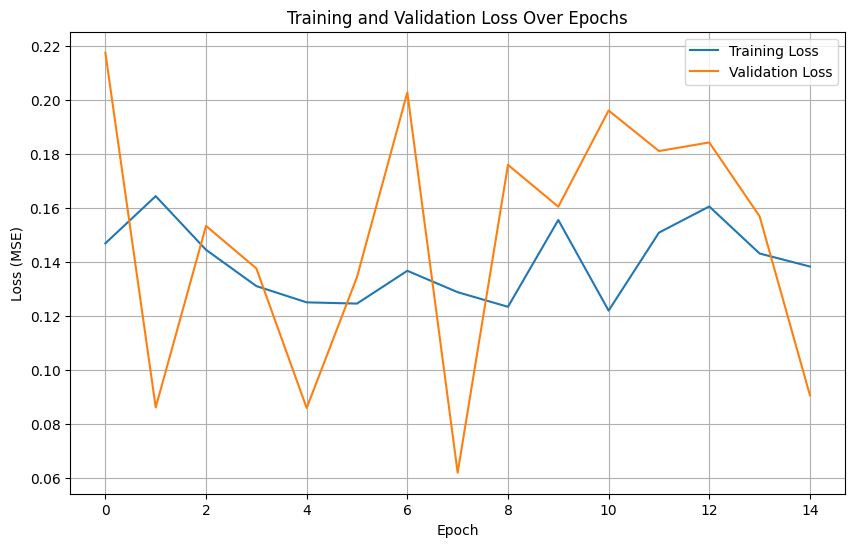

In [12]:
# ==============================================================================
# 6. PLOT TRAINING AND VALIDATION LOSS
# ==============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# ==============================================================================
# 7. SAVE THE FINAL EMBEDDING
# ==============================================================================
from safetensors.torch import save_file
import torch
import os

# Ensure output directory exists
os.makedirs(config.output_dir, exist_ok=True)

# Get the trained embedding vector
unwrapped_text_encoder = accelerator.unwrap_model(text_encoder)
learned_embedding = unwrapped_text_encoder.get_input_embeddings().weight[placeholder_token_id]

# Create dictionary in the expected format
embedding_dict = {config.placeholder_token: learned_embedding.detach().cpu()}

# Save as PyTorch
pt_path = os.path.join(config.output_dir, f"ghibliTI.pt")
torch.save(embedding_dict, pt_path)

# Save as Safetensors (recommended for sharing)
st_path = os.path.join(config.output_dir, f"ghiblivisTI.safetensors")
save_file(embedding_dict, st_path)

print(f"‚úÖ Embedding saved as:\n- {os.path.abspath(pt_path)}\n- {os.path.abspath(st_path)}")


‚úÖ Embedding saved as:
- C:\Users\Dell - G15\Desktop\Thesis Code\ghiblivis-TI(NEW)\ghibliTI.pt
- C:\Users\Dell - G15\Desktop\Thesis Code\ghiblivis-TI(NEW)\ghiblivisTI.safetensors


In [20]:
# ==============================================================================
# 8. LOAD THE SAVE TI SAFETENSORS AND GENERATE IMAGES
# ==============================================================================
from diffusers import StableDiffusionPipeline
import torch

# Loading base model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Load the textual inversion embedding
pipe.load_textual_inversion(st_path, token=config.placeholder_token)

# Test prompt with placeholder token
prompt = f"An image of{config.placeholder_token}, ghiblivis Petra, Jordan, ancient Nabataean city, monumental rock-cut tomb facade, intricate multi-level structure carved directly into rose-red sandstone cliff, soft white clouds, warm natural sunlight illuminating the sandstone, delicate play of light and shadow on the carved details, serene and timeless atmosphere, whimsical, dreamlike"

# Generate image
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image.save(os.path.join(config.output_dir, "5test_output.png"))

print("üñº Test image saved to:", os.path.join(config.output_dir, "5test_output.png"))


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

üñº Test image saved to: ghiblivis-TI(NEW)\5test_output.png


## CLIP score // LPIPS // FID

In [ ]:
pip install clip-anytorch pillow scikit-learn clean-fid tqdm

In [3]:
# ====== CLIP scoring (Hugging Face transformers) ======
# pip install transformers torch torchvision pillow pandas tqdm
# ==========
# LORA
# ==========
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

# ------------------------------
# CONFIG
# ------------------------------
images_folder = "ghiblivis-LORA(NEW)"  # change to your folder
prompts = [
    # One prompt per image, matched by index to sorted filenames
    "ghiblivis Petra, Jordan, monumental rock-cut tomb facade, arched openings, weathered stone details, towering rock formations, clear bright sky, soft white clouds, warm sunlight on sandstone, delicate light and shadow on carvings, serene atmosphere, whimsical, dreamlike, rich colors, soft daylight, pastel sky and sand, painterly rock textures, carved stone texture, grand scale",
    "ghiblivis Big Ben, Elizabeth Tower, stone carvings, tall spire, Victorian building, over River Thames, calm water, city skyline, vibrant sunset, warm oranges, reds, pinks, blues, fluffy clouds, radiant glow, grand urban scene, whimsical, dreamlike, rich colors, soft light, pastel sky, painterly textures, atmospheric, serene, urban fantasy, historical landmark",
    "ghiblivis Bab-e-Khyber, Pakistan, historic stone gateway, two round towers with battlements, grand archway, rough-hewn stone, Pakistani flag on top, road with cars and people, distant buildings, bright sky, soft daylight, frontal view through arch, whimsical, dreamlike, vibrant colors, pastel tones, painterly, intricate, serene, cultural landmark, lively scene",
    "ghiblivis Colosseum, Rome, ancient oval amphitheater, weathered stone arches, partially ruined, illuminated at night with warm golden light, deep blue sky with stars, soft moon glow, lush green grass and pathways, peaceful and magical atmosphere, whimsical, dreamlike, vibrant colors, pastel tones, painterly textures, intricate details, serene, historical fantasy, ancient wonder",
    "ghiblivis Sydney Opera House, iconic white sail-like roofs, layered shell structures, intricate tiles, modern base, shimmering blue Sydney Harbour, boats and ferries, lush green headlands, city skyline with skyscrapers, bright sunny day, clear blue sky, soft clouds, high aerial view, panoramic harbour vista, whimsical, dreamlike, vibrant colors, pastel tones, painterly textures, intricate details, serene, majestic scene",
]

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"

# ------------------------------
# LOAD MODEL & PROCESSOR
# ------------------------------
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)
max_len = processor.tokenizer.model_max_length  # typically 77

# ------------------------------
# COLLECT IMAGE FILES (images only)
# ------------------------------
image_files = sorted([
    f for f in os.listdir(images_folder)
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".webp", ".bmp"))
])

# Basic sanity check
if len(image_files) != len(prompts):
    raise ValueError(
        f"Number of images ({len(image_files)}) != number of prompts ({len(prompts)}). "
        "Ensure prompts align index-wise with sorted filenames."
    )

def will_truncate(text: str) -> bool:
    toks = processor.tokenizer(text, add_special_tokens=True, return_tensors="pt")
    return toks["input_ids"].shape[1] > max_len

# ------------------------------
# SCORE LOOP
# ------------------------------
rows = []
for img_file, prompt in tqdm(list(zip(image_files, prompts)), total=len(image_files), desc="Scoring"):
    if will_truncate(prompt):
        print(f"‚ö†Ô∏è Prompt will be truncated to {max_len} tokens:\n   {prompt[:120]}...")

    # Load image
    img_path = os.path.join(images_folder, img_file)
    image = Image.open(img_path).convert("RGB")

    # Tokenize with forced truncation/padding to 77
    text_inputs = processor.tokenizer(
        [prompt],
        padding="max_length",
        max_length=max_len,
        truncation=True,
        return_tensors="pt",
    )

    # Image preprocessing to pixel_values
    image_inputs = processor(images=[image], return_tensors="pt")

    # Move to device
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    pixel_values = image_inputs["pixel_values"].to(device)

    with torch.no_grad():
        out = model(
            input_ids=text_inputs["input_ids"],
            attention_mask=text_inputs["attention_mask"],
            pixel_values=pixel_values,
        )
        img_emb = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt_emb = out.text_embeds / out.text_embeds.norm(dim=-1, keepdim=True)
        score = (img_emb @ txt_emb.T).item()  # cosine similarity

    rows.append({"Image": img_file, "Prompt": prompt, "CLIP Score": round(score, 4)})

# ------------------------------
# RESULTS
# ------------------------------
df = pd.DataFrame(rows)
print(df)


Scoring:   0%|                                                                                   | 0/5 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors


‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Petra, Jordan, monumental rock-cut tomb facade, arched openings, weathered stone details, towering rock format...


Scoring:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 3/5 [00:00<00:00,  8.85it/s]

‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Big Ben, Elizabeth Tower, stone carvings, tall spire, Victorian building, over River Thames, calm water, city ...
‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Bab-e-Khyber, Pakistan, historic stone gateway, two round towers with battlements, grand archway, rough-hewn s...
‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Sydney Opera House, iconic white sail-like roofs, layered shell structures, intricate tiles, modern base, shim...


Scoring: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:00<00:00,  9.85it/s]

   Image                                             Prompt  CLIP Score
0  1.png  ghiblivis Petra, Jordan, monumental rock-cut t...      0.2032
1  2.png  ghiblivis Big Ben, Elizabeth Tower, stone carv...      0.3134
2  3.png  ghiblivis Bab-e-Khyber, Pakistan, historic sto...      0.3209
3  4.png  ghiblivis Colosseum, Rome, ancient oval amphit...      0.2091
4  5.png  ghiblivis Sydney Opera House, iconic white sai...      0.3120


In [5]:
# ====== CLIP scoring (Hugging Face transformers) ======
# pip install transformers torch torchvision pillow pandas tqdm
# ==========
# TEXTUAL INVERSION
# ==========
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

# ------------------------------
# CONFIG
# ------------------------------
images_folder = "ghiblivis-TI(NEW)"  # change to your folder
prompts = [
    "ghiblivis Big Ben, Elizabeth Tower, stone carvings, tall spire, Victorian building, over River Thames, calm water, city skyline, vibrant sunset, warm oranges, reds, pinks, blues, fluffy clouds, radiant glow, grand urban scene, whimsical, dreamlike, rich colors, soft light, pastel sky, painterly textures, atmospheric, serene, urban fantasy, historical landmark",
    "ghiblivis Bab-e-Khyber, Pakistan, historic stone gateway, two round towers with battlements, grand archway, rough-hewn stone, Pakistani flag on top, road with cars and people, distant buildings, bright sky, soft daylight, frontal view through arch, whimsical, dreamlike, vibrant colors, pastel tones, painterly, intricate, serene, cultural landmark, lively scene",
    "ghiblivis Sydney Opera House, iconic white sail-like roofs, layered shell structures, intricate tiles, modern base, shimmering blue Sydney Harbour, boats and ferries, lush green headlands, city skyline with skyscrapers, bright sunny day, clear blue sky, soft clouds, high aerial view, panoramic harbour vista, whimsical, dreamlike, vibrant colors, pastel tones, painterly textures, intricate details, serene, majestic scene",
    "ghiblivis Colosseum, Rome, ancient oval amphitheater, weathered stone arches, partially ruined, illuminated at night with warm golden light, deep blue sky with stars, soft moon glow, lush green grass and pathways, peaceful and magical atmosphere, whimsical, dreamlike, vibrant colors, pastel tones, painterly textures, intricate details, serene, historical fantasy, ancient wonder",
    "ghiblivis Petra, Jordan, monumental rock-cut tomb facade, arched openings, weathered stone details, towering rock formations, clear bright sky, soft white clouds, warm sunlight on sandstone, delicate light and shadow on carvings, serene atmosphere, whimsical, dreamlike, rich colors, soft daylight, pastel sky and sand, painterly rock textures, carved stone texture, grand scale"
    
]

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"

# ------------------------------
# LOAD MODEL & PROCESSOR
# ------------------------------
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)
max_len = processor.tokenizer.model_max_length  # typically 77

# ------------------------------
# COLLECT IMAGE FILES (images only)
# ------------------------------
image_files = sorted([
    f for f in os.listdir(images_folder)
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".webp", ".bmp"))
])

# Basic sanity check
if len(image_files) != len(prompts):
    raise ValueError(
        f"Number of images ({len(image_files)}) != number of prompts ({len(prompts)}). "
        "Ensure prompts align index-wise with sorted filenames."
    )

def will_truncate(text: str) -> bool:
    toks = processor.tokenizer(text, add_special_tokens=True, return_tensors="pt")
    return toks["input_ids"].shape[1] > max_len

# ------------------------------
# SCORE LOOP
# ------------------------------
rows = []
for img_file, prompt in tqdm(list(zip(image_files, prompts)), total=len(image_files), desc="Scoring"):
    if will_truncate(prompt):
        print(f"‚ö†Ô∏è Prompt will be truncated to {max_len} tokens:\n   {prompt[:120]}...")

    # Load image
    img_path = os.path.join(images_folder, img_file)
    image = Image.open(img_path).convert("RGB")

    # Tokenize with forced truncation/padding to 77
    text_inputs = processor.tokenizer(
        [prompt],
        padding="max_length",
        max_length=max_len,
        truncation=True,
        return_tensors="pt",
    )

    # Image preprocessing to pixel_values
    image_inputs = processor(images=[image], return_tensors="pt")

    # Move to device
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    pixel_values = image_inputs["pixel_values"].to(device)

    with torch.no_grad():
        out = model(
            input_ids=text_inputs["input_ids"],
            attention_mask=text_inputs["attention_mask"],
            pixel_values=pixel_values,
        )
        img_emb = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt_emb = out.text_embeds / out.text_embeds.norm(dim=-1, keepdim=True)
        score = (img_emb @ txt_emb.T).item()  # cosine similarity

    rows.append({"Image": img_file, "Prompt": prompt, "CLIP Score": round(score, 4)})

# ------------------------------
# RESULTS
# ------------------------------
df = pd.DataFrame(rows)
print(df)


Scoring:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 2/5 [00:00<00:00, 19.76it/s]

‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Big Ben, Elizabeth Tower, stone carvings, tall spire, Victorian building, over River Thames, calm water, city ...
‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Bab-e-Khyber, Pakistan, historic stone gateway, two round towers with battlements, grand archway, rough-hewn s...
‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Sydney Opera House, iconic white sail-like roofs, layered shell structures, intricate tiles, modern base, shim...
‚ö†Ô∏è Prompt will be truncated to 77 tokens:
   ghiblivis Petra, Jordan, monumental rock-cut tomb facade, arched openings, weathered stone details, towering rock format...


Scoring: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:00<00:00, 21.13it/s]

   Image                                             Prompt  CLIP Score
0  1.png  ghiblivis Big Ben, Elizabeth Tower, stone carv...      0.2508
1  2.png  ghiblivis Bab-e-Khyber, Pakistan, historic sto...      0.3314
2  3.png  ghiblivis Sydney Opera House, iconic white sai...      0.3040
3  4.png  ghiblivis Colosseum, Rome, ancient oval amphit...      0.2006
4  5.png  ghiblivis Petra, Jordan, monumental rock-cut t...      0.2369


In [12]:
# ==================================
# LORA  (FID // LPIPS)
# ==================================


import os
from PIL import Image
import torch
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

# ==================================
# CONFIG
# ==================================
generated_dir = "./ghiblivis-LORA(NEW)"    # folder with your generated images (e.g., 1.png, BigBen.png, ...)
reference_dir = "./ghiblivis-LORA(NEW)/reference"  # root folder containing per-landmark subfolders with real images
# Example: reference_dir/Petra/, reference_dir/BigBen/, ...

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==================================
# HELPERS
# ==================================
def list_images(folder):
    return sorted([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".webp"))
    ])

# transform for FID (InceptionV3 expects 299x299)
tfm_fid = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

# transform for LPIPS (often evaluated at 256x256)
tfm_lpips = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def load_images_for_metric(image_paths, tfm, device):
    imgs = []
    for p in image_paths:
        img = Image.open(p).convert("RGB")
        imgs.append(tfm(img).unsqueeze(0))
    return torch.cat(imgs, dim=0).to(device)

# ==================================
# 1. OVERALL FID
# ==================================
fid = FrechetInceptionDistance(normalize=True).to(device)

# Collect all generated and reference images
gen_paths = list_images(generated_dir)
ref_paths = []
for sub in os.listdir(reference_dir):
    ref_paths.extend(list_images(os.path.join(reference_dir, sub)))

# Update FID metric
fid.update(load_images_for_metric(ref_paths, tfm_fid, device), real=True)
fid.update(load_images_for_metric(gen_paths, tfm_fid, device), real=False)

overall_fid = float(fid.compute())
print(f"‚úÖ Overall FID: {overall_fid:.3f}")

# ==================================
# 2. PER-LANDMARK LPIPS
# ==================================
lpips_metric = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

print("\nPer-landmark LPIPS (lower is better):")
for g_path in gen_paths:
    landmark_name = os.path.splitext(os.path.basename(g_path))[0]
    ref_folder = os.path.join(reference_dir, landmark_name)
    ref_imgs = list_images(ref_folder)

    if not ref_imgs:
        print(f"  {landmark_name}: No reference images found.")
        continue

    gen_img = tfm_lpips(Image.open(g_path).convert("RGB")).unsqueeze(0).to(device)
    gen_img = gen_img * 2 - 1  # scale to [-1, 1]

    scores = []
    with torch.no_grad():
        for r_path in ref_imgs:
            ref_img = tfm_lpips(Image.open(r_path).convert("RGB")).unsqueeze(0).to(device)
            ref_img = ref_img * 2 - 1  # scale to [-1, 1]
            score = lpips_metric(gen_img, ref_img).item()
            scores.append(score)

    avg_lpips = sum(scores) / len(scores)
    print(f"  {landmark_name}: LPIPS = {avg_lpips:.4f} (refs: {len(ref_imgs)})")


‚úÖ Overall FID: 193.547

Per-landmark LPIPS (lower is better):
  BabEKhyber: LPIPS = 0.7223 (refs: 4)
  BigBen: LPIPS = 0.8590 (refs: 2)
  Colosseum: LPIPS = 0.6347 (refs: 5)
  Petra: LPIPS = 0.6836 (refs: 4)
  SydneyOperaHouse: LPIPS = 0.6747 (refs: 6)


In [11]:
# ==================================
# Textual Inversion (FID // LPIPS)
# ==================================


import os
from PIL import Image
import torch
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

# ==================================
# CONFIG
# ==================================
generated_dir = "./ghiblivis-TI(NEW)"    # folder with your generated images (e.g., 1.png, BigBen.png, ...)
reference_dir = "./ghiblivis-TI(NEW)/reference"  # root folder containing per-landmark subfolders with real images
# Example: reference_dir/Petra/, reference_dir/BigBen/, ...

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==================================
# HELPERS
# ==================================
def list_images(folder):
    return sorted([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".webp"))
    ])

# transform for FID (InceptionV3 expects 299x299)
tfm_fid = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

# transform for LPIPS (often evaluated at 256x256)
tfm_lpips = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def load_images_for_metric(image_paths, tfm, device):
    imgs = []
    for p in image_paths:
        img = Image.open(p).convert("RGB")
        imgs.append(tfm(img).unsqueeze(0))
    return torch.cat(imgs, dim=0).to(device)

# ==================================
# 1. OVERALL FID
# ==================================
fid = FrechetInceptionDistance(normalize=True).to(device)

# Collect all generated and reference images
gen_paths = list_images(generated_dir)
ref_paths = []
for sub in os.listdir(reference_dir):
    ref_paths.extend(list_images(os.path.join(reference_dir, sub)))

# Update FID metric
fid.update(load_images_for_metric(ref_paths, tfm_fid, device), real=True)
fid.update(load_images_for_metric(gen_paths, tfm_fid, device), real=False)

overall_fid = float(fid.compute())
print(f"‚úÖ Overall FID: {overall_fid:.3f}")

# ==================================
# 2. PER-LANDMARK LPIPS
# ==================================
lpips_metric = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

print("\nPer-landmark LPIPS (lower is better):")
for g_path in gen_paths:
    landmark_name = os.path.splitext(os.path.basename(g_path))[0]
    ref_folder = os.path.join(reference_dir, landmark_name)
    ref_imgs = list_images(ref_folder)

    if not ref_imgs:
        print(f"  {landmark_name}: No reference images found.")
        continue

    gen_img = tfm_lpips(Image.open(g_path).convert("RGB")).unsqueeze(0).to(device)
    gen_img = gen_img * 2 - 1  # scale to [-1, 1]

    scores = []
    with torch.no_grad():
        for r_path in ref_imgs:
            ref_img = tfm_lpips(Image.open(r_path).convert("RGB")).unsqueeze(0).to(device)
            ref_img = ref_img * 2 - 1  # scale to [-1, 1]
            score = lpips_metric(gen_img, ref_img).item()
            scores.append(score)

    avg_lpips = sum(scores) / len(scores)
    print(f"  {landmark_name}: LPIPS = {avg_lpips:.4f} (refs: {len(ref_imgs)})")


‚úÖ Overall FID: 198.317

Per-landmark LPIPS (lower is better):
  BabEKhyber: LPIPS = 0.7310 (refs: 4)
  BigBen: LPIPS = 0.7170 (refs: 2)
  Colosseum: LPIPS = 0.7194 (refs: 5)
  Petra: LPIPS = 0.7179 (refs: 4)
  SydneyOperaHouse: LPIPS = 0.7645 (refs: 6)
